# 04 :: Statistical Leverage Distributions

**Objectives:**

* Inspect the gene and spot leverage score distributions.
* If the gene (column) leverage scores are non-uniform, we can use these scores for feature selection/dimensionality reduction by discarding low leverage genes.

In [211]:
# %load common.py
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

GT = 'GT'
YEN = 'AB1_StdDev_Yen'
REGION = 'Region_predict'
ASTROCYTE = 'astrocyte'
NEURON = 'neuron'
INTERNEURON = 'interneuron'
AGE = 'age'
DAYS = 'age_days'
MONTHS = 'age_months'
AGE_GT ='age_GT'
SAMPLE_ID = 'sampleID'
SPOT_UID = 'spot_UID'
SLIDE_ID = 'slide_ID'

# The merged data file in Parquet format.

parquet = '/media/tmo/data/work/datasets/02_ST/parquet/'
st_full = parquet + 'st_full'

def read_full(path=st_full):
    return pd.read_parquet(st_full)

def enrich(full):
    # Add age column (young, old)
    full[AGE] = np.where(full[MONTHS] < 10, 'young', 'old')
    
    # Add combined column age_GT.
    full[AGE_GT] = full[[AGE, GT]].apply(lambda x: '_'.join(x), axis=1)
    
    # parse slide ID
    full['slide_ID'] = full[SPOT_UID].apply(lambda x: str(x).split('__')[0])
    
    return full

def read_enriched(path=st_full):
    return enrich(read_full(path))
    
# TODO
# * add 'coarse_region' that joins regions with <500 entries in them into one region OTHER

In [212]:
full = read_enriched()

CPU times: user 9.03 s, sys: 15.2 s, total: 24.2 s
Wall time: 9.48 s


In [213]:
n_genes = 46454

In [214]:
gene_cols = full.columns[1:n_genes+1]

In [215]:
ex_matrix = full[gene_cols].as_matrix()

In [216]:
ex_matrix.shape

(10327, 46454)

---

# Leverage scores

> Jiyan Yang, Oliver Rubel, Prabhat, Michael W. Mahoney, and Ben P. Bowen, Identifying Important Ions and Positions in Mass Spectrometry Imaging Data Using CUR Matrix Decompositions. Analytical Chemistry, 87(9), 4658-4666, 2015.

* see: https://github.com/chocjy/CUR-CX-MSI
* `Fro` = Frobenius / `Spe` = Spectral
* `fht` = Fast Hadamard Transform

## **Strategy**

If we can pull it off to compute the exact SVD of the ST, expression matrix we can use `compute_leverage_exact` to compute the column and row leverage scores without bothering with the Spectral or Frobenius norm approximate leverage scores.

In [7]:
from scipy.linalg import svd

In [8]:
%%time
U, s, V = svd(ex_matrix)

CPU times: user 1h 26min 3s, sys: 19min 5s, total: 1h 45min 9s
Wall time: 2min 55s


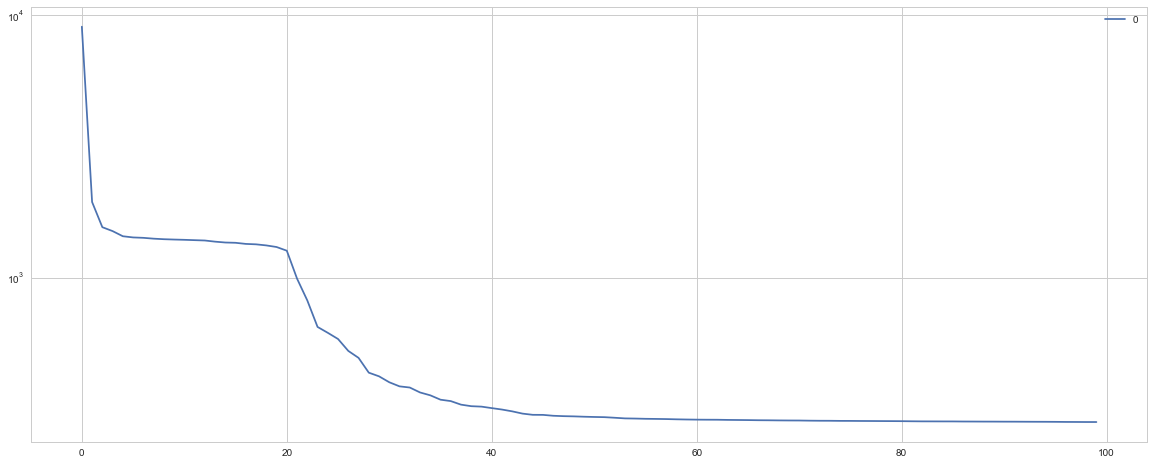

In [21]:
pd.DataFrame(s[:100]).plot(logy=True, figsize=(20,8))
plt.show()

* it's remarkable to see that the column leverage scores have this 'elbow' at ~20 == the number of slides. (batch effect?)

**TODO**
* grid/random search for best parameters: k and 
* k is not necessarily identical in both (gene and spot) cases

In [299]:
row_k = 60
col_k = 60  # guess based on the plot above

def to_lev_df(lev_values):
    return pd.DataFrame(lev_values, columns=['leverage'])

def to_row_lev_scores(U, k):
    row_lev_values = np.sum(U[:,:k]**2, axis=1)
    
    return to_lev_df(row_lev_values)    

def to_col_lev_scores(V, k):
    col_lev_values = np.sum(V[:k,:]**2,axis=0)
    
    return to_lev_df(col_lev_values)

In [292]:
row_lev_df = to_row_lev_scores(U, row_k)
col_lev_df = to_col_lev_scores(V, col_k)

col_lev_stats = col_lev_df.describe()
col_lev_min = col_lev_stats.loc['min'][0]
col_lev_std = col_lev_stats.loc['std'][0]

In [293]:
row_lev_with_slide_df = row_lev_df.merge(full[[SLIDE_ID]], left_index=True, right_index=True)

In [294]:
row_lev_df.head()

,leverage
0,0.002771
1,0.005871
2,0.003884
3,0.007442
4,0.002621


In [295]:
row_lev_with_slide_df.head()

,leverage,slide_ID
0,0.002771,B02_D1
0,0.002771,B02_E1
0,0.002771,B03_C2
0,0.002771,B03_D2
0,0.002771,B04_D1


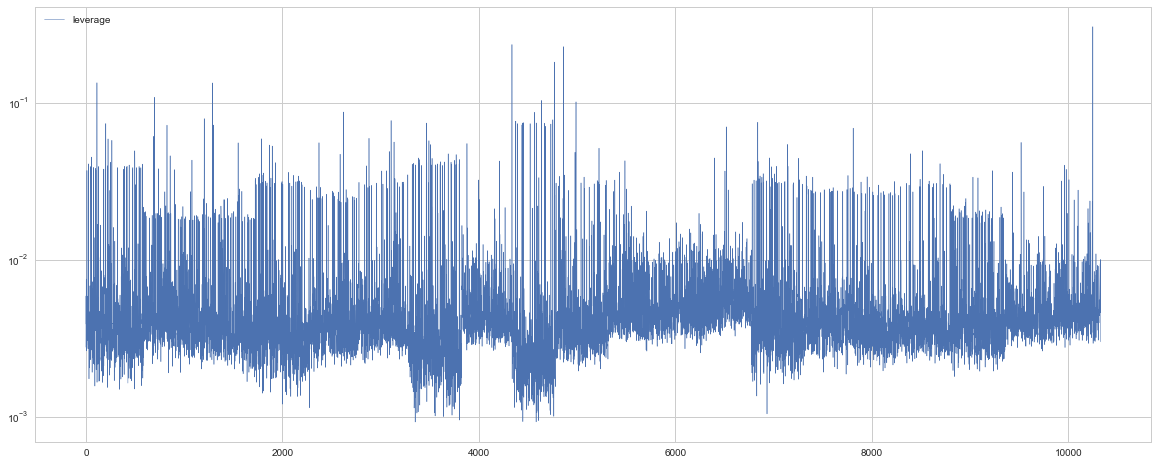

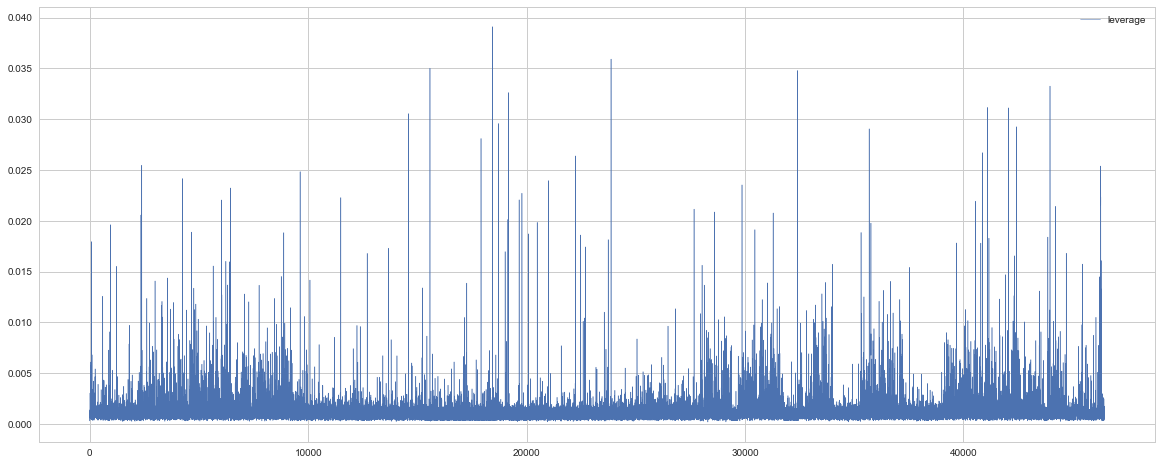

In [297]:
row_lev_df.plot(figsize=(20, 8), linewidth=0.5, logy=True)
col_lev_df.plot(figsize=(20, 8), linewidth=0.5)
plt.show()

* batch effect present in row leverage scores
* todo correlate this with slide info

In [298]:
col_lev_stats

,leverage
count,46454.000000
mean,0.001292
std,0.001348
min,0.000192
25%,0.000728
50%,0.001050
75%,0.001461
max,0.039117


## Distribution of highest leverage scores

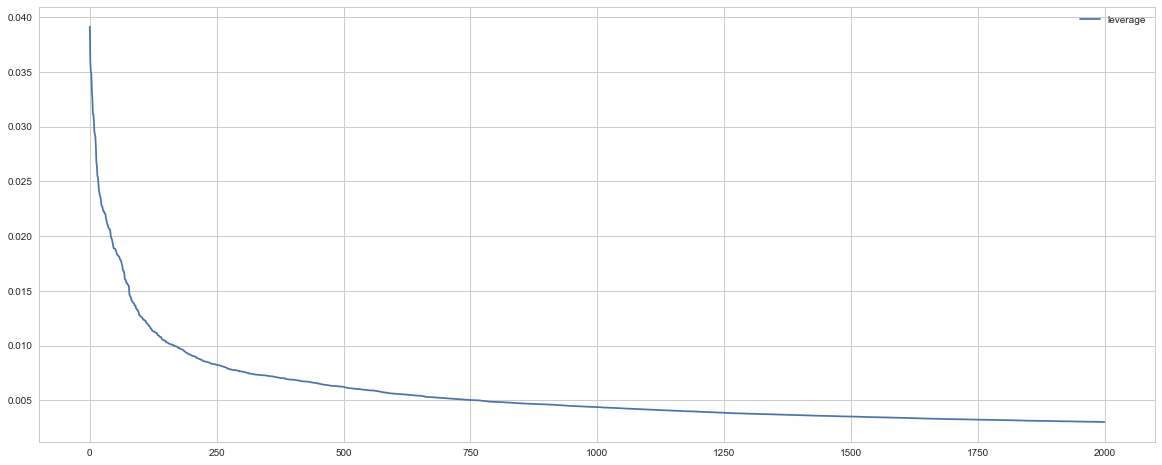

In [312]:
col_lev_df.sort_values(by='leverage', ascending=False)[:2000].plot(figsize=(20,8), use_index=False)
plt.show()

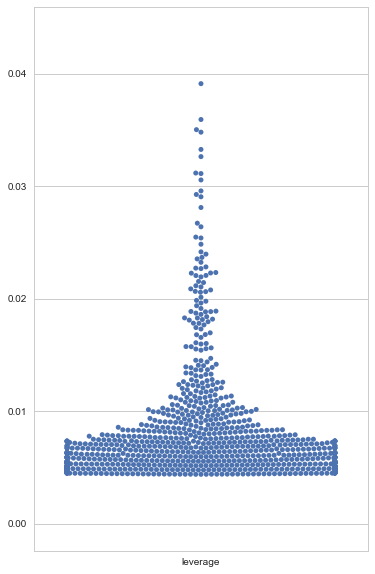

In [137]:
fig, ax = plt.subplots(figsize=(6, 10))
sns.swarmplot(data=col_lev_df.sort_values(by='leverage', ascending=False)[:1000])
plt.show()

* which genes associated with high leverage scores?

In [317]:
col_lev_ranked_df = col_lev_df.sort_values(by='leverage', ascending=False)

pd.DataFrame(gene_cols) \
    .merge(col_lev_ranked_df.head(top_lev), 
           left_index=True, 
           right_index=True) \
    .sort_values(by='leverage', ascending=False)

,0,leverage
18440,Gm26228,0.039117
23867,Gm44074,0.035930
15575,Gm21956,0.035028
32402,Mir8105,0.034804
43965,Trim50,0.033270
19177,Gm27221,0.032631
41093,Skor2,0.031172
42056,Sppl2c,0.031127
14601,Gm18301,0.030557
18708,Gm26599,0.029585


In [320]:
ranked_gene_lev_df = pd.DataFrame(gene_cols) \
    .merge(col_lev_df.sort_values(by='leverage', ascending=False), 
           left_index=True, 
           right_index=True) \
    .sort_values(by='leverage', ascending=False)
    
ranked_gene_lev_df.columns = ['gene', 'leverage']    
ranked_gene_lev_df.head()

,gene,leverage
18440,Gm26228,0.039117
23867,Gm44074,0.035930
15575,Gm21956,0.035028
32402,Mir8105,0.034804
43965,Trim50,0.033270


In [321]:
ranked_gene_lev_df.to_csv('ranked_gene_leverage.tsv', sep='\t')

# find optimal k